#Mount Google Drive dan Load Dataset

In [ ]:
# Import pustaka
import pandas as pd
import os
from google.colab import drive

drive.mount('/content/drive')

# Akses path
path = '/content/drive/MyDrive/data_oleh_oleh'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Kolom di df_cat:", df_cat.columns.tolist())

Kolom di df_cat: ['id_tempat', 'kategori']


In [ ]:
# SISTEM REKOMENDASI OLEH-OLEH DI KOTA SORONG (XGBoost + VGG16 + NCF)

# Tahap 1: Load Semua File CSV
import pandas as pd
import io

# Menggunakan path yang benar ke file CSV di Google Drive
path = '/content/drive/MyDrive/data_oleh_oleh'

# Load df_img, df_rating, df_tempat and df_cat with comma delimiter
df_img = pd.read_csv(f'{path}/image_labels_cleaned.csv', sep=';', engine='python')
df_rating = pd.read_csv(f'{path}/user_rating_cleaned.csv', sep=';')
df_tempat = pd.read_csv(f'{path}/tempat_cleaned.csv', sep=';')
df_cat = pd.read_csv(f'{path}/category_map_cleaned.csv', sep=';')
df_cat.columns = df_cat.columns.str.strip()

# Bersihkan nama kolom (hapus spasi di awal/akhir)
df_img.columns = df_img.columns.str.strip()
df_rating.columns = df_rating.columns.str.strip()
df_tempat.columns = df_tempat.columns.str.strip()
df_cat.columns = df_cat.columns.str.strip()

# Convert 'id_tempat' in df_tempat to string to match df_rating['tempat_id'] format
# Assuming id_tempat values like 1.0, 2.0 correspond to 'T001', 'T002'
df_tempat['id_tempat'] = 'T' + df_tempat['id_tempat'].astype(int).astype(str).str.zfill(3)

print(df_cat['id_tempat'].unique())
print(df_cat['id_tempat'].isnull().sum())  # Cek apakah ada NaN

# Convert 'id_tempat' in df_cat to string to match df_tempat['id_tempat'] format
df_cat['id_tempat'] = 'T' + df_cat['id_tempat'].astype(int).astype(str).str.zfill(3)


# Print column names and types to verify
print("Columns in df_tempat:", df_tempat.columns)
print("Data types in df_tempat:\n", df_tempat.dtypes)
print("Columns in df_cat:", df_cat.columns)
print("Data types in df_cat:\n", df_cat.dtypes)
print("Columns in df_rating:", df_rating.columns)
print("Data types in df_rating:\n", df_rating.dtypes)


# Gabungkan tempat dan kategori
df_tempat = df_tempat.merge(df_cat, on='id_tempat', how='left')

[1 2]
0
Columns in df_tempat: Index(['NAMA_TOKO', 'jenis produk', 'rating', 'id_tempat', 'gambar'], dtype='object')
Data types in df_tempat:
 NAMA_TOKO       object
jenis produk    object
rating           int64
id_tempat       object
gambar          object
dtype: object
Columns in df_cat: Index(['id_tempat', 'kategori'], dtype='object')
Data types in df_cat:
 id_tempat    object
kategori     object
dtype: object
Columns in df_rating: Index(['user_id,tempat_id,rating'], dtype='object')
Data types in df_rating:
 user_id,tempat_id,rating    object
dtype: object


In [ ]:
# Inspect raw content of tempat_cleaned.csv
path = '/content/drive/MyDrive/data_oleh_oleh'
with open(f'{path}/tempat_cleaned.csv', 'r') as f:
    for i in range(5): # Print first 5 lines
        print(f.readline())

# Inspect raw content of user_rating_cleaned.csv
with open(f'{path}/user_rating_cleaned.csv', 'r') as f:
    for i in range(5): # Print first 5 lines
        print(f.readline())

﻿NAMA_TOKO;jenis produk;rating;id_tempat;gambar

kaokanako shop;souvenir;4;2;"noken1.jpg; noken2.jpg; noken3.jpg; noken4.jpg; noken5.jpg; noken6.jpg; noken7.jpg; noken8.jpg; noken9.jpg; noken10.jpg; noken11.jpg; noken12.jpg; noken13.jpg; noken14.jpg; noken15.jpg; noken16.jpg; noken17.jpg; noken18.jpg; noken19.jpg; noken20.jpg; noken21.jpg; noken22.jpg; noken23.jpg; noken24.jpg; noken25.jpg; noken26.jpg; noken27.jpg; noken28.jpg; noken29.jpg; noken30.jpg; noken31.jpg; noken32.jpg; noken33.jpg; noken34.jpg; noken35.jpg; noken36.jpg; noken37.jpg; noken38.jpg; noken39.jpg; noken40.jpg; noken41.jpg; noken42.jpg; noken43.jpg; noken44.jpg; noken45.jpg; noken46.jpg; noken47.jpg; noken48.jpg; noken49.jpg; noken50.jpg; noken51.jpg; noken52.jpg; noken53.jpg; noken54.jpg; noken55.jpg; noken56.jpg; noken57.jpg; noken58.jpg; noken59.jpg; noken60.jpg; noken61.jpg; noken62.jpg; noken63.jpg; noken64.jpg; noken65.jpg; noken66.jpg; noken67.jpg; noken68.jpg; noken69.jpg; noken70.jpg; noken71.jpg; noken72.

In [ ]:
import pandas as pd

# Data mentah manual (bisa disimpan di .txt lalu dibaca)
raw_data = '''
kaokanako shop,souvenir,4.0,2.0,"noken_1.JPG, noken_2.JPG, ..., noken_41.JPG"
pesona etnik papua,souvenir,5.0,2.0,"noken_42.JPG, ..., noken_82.JPG"
billy bakery,oleh-oleh,5.0,1.0,"abon_gulung1.JPG, abon_gulung2.JPG"
'''

# Simulasi parsing manual (dalam kasus real: simpan sebagai CSV lalu pd.read_csv)
rows = []
for line in raw_data.strip().split("\n"):
    if not line.strip(): continue
    parts = line.split(",")
    nama_toko = parts[0]
    jenis_produk = parts[1]
    rating = float(parts[2])
    id_tempat = parts[3]
    images = ",".join(parts[4:]).replace('\"','').split(",")
    for img in images:
        rows.append({
            "nama_toko": nama_toko.strip(),
            "jenis_produk": jenis_produk.strip(),
            "rating": rating,
            "id_tempat": id_tempat.strip(),
            "image_name": img.strip()
        })

df_images = pd.DataFrame(rows)
df_images.to_csv("image_labels_cleaned.csv", index=False)
print("✔️ image_labels_cleaned.csv disimpan")

# Simpan data rating user
user_rating_data = """user_id,tempat_id,rating
1,T001,4
1,T002,5
2,T002,3
2,T003,4
"""

with open("user_rating_cleaned.csv", "w") as f:
    f.write(user_rating_data)

print("✔️ user_rating_cleaned.csv disimpan")


✔️ image_labels_cleaned.csv disimpan
✔️ user_rating_cleaned.csv disimpan


In [ ]:
with open(f'{path}/image_labels_cleaned.csv') as f:
    for _ in range(5):
        print(f.readline())

image_path,label

/content/drive/MyDrive/data_oleh_oleh/souvenir/noken_papua/noken1.JPG,souvenir

/content/drive/MyDrive/data_oleh_oleh/souvenir/noken_papua/noken2.JPG,souvenir

/content/drive/MyDrive/data_oleh_oleh/souvenir/noken_papua/noken3.JPG,souvenir

/content/drive/MyDrive/data_oleh_oleh/souvenir/noken_papua/noken4.JPG,souvenir



In [ ]:
from PIL import Image
import os
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

# Helper to adjust subfolder path
# Menambahkan dukungan untuk keripik_keladi

def get_image_subfolder(label, image_name):
    if label == 'souvenir':
        return 'souvenir/noken_papua'
    elif label == 'oleh-oleh':
        if 'abon' in image_name.lower():
            return 'oleh_oleh/abon_gulung'
        elif 'keladi' in image_name.lower():
            return 'oleh_oleh/keripik_keladi'
        else:
            return 'oleh_oleh'  # fallback jika tidak dikenali
    else:
        return label

# Fix image_name containing '...'
# It seems df_img loaded from the CSV does not have 'image_name' column.
# The image name is part of the 'image_path,label' column.
# I will skip this line as it's based on the manually created df_images.
# df_img = df_img[df_img['image_path'] != '...']

# Split the 'image_path,label' column into two separate columns
df_img[['image_path', 'label']] = df_img['image_path,label'].str.split(',', expand=True)

# Perbaiki nama file noken yang salah format
# Ubah "noken_1.JPG" → "noken1.JPG"
# I will extract the image name from the path first.
df_img['image_name_extracted'] = df_img['image_path'].apply(lambda x: os.path.basename(x))
df_img.loc[df_img['label'] == 'souvenir', 'image_name_extracted'] = df_img.loc[df_img['label'] == 'souvenir', 'image_name_extracted'].str.replace('noken_', 'noken', regex=False)


# Correct the image path based on actual folder structure
# Reconstruct the image path using the corrected image name
df_img['image_path'] = df_img.apply(
    lambda row: f"/content/drive/MyDrive/data_oleh_oleh/{get_image_subfolder(row['label'], row['image_name_extracted'])}/{row['image_name_extracted']}",
    axis=1
)

# Validate image paths using the is_image_valid function
def is_image_valid(path):
    try:
        if not os.path.exists(path):
            return False
        Image.open(path)
        return True
    except Exception:
        return False

df_img['image_exists'] = df_img['image_path'].apply(is_image_valid)
print("Jumlah gambar tidak valid:", (~df_img['image_exists']).sum())

# Label encoding for the 'label' column
le = LabelEncoder()
df_img['label_encoded'] = le.fit_transform(df_img['label'])

# Display the first few rows with the new columns
display(df_img.head())

Jumlah gambar tidak valid: 1001


,"image_path,label",image_path,label,image_name_extracted,image_exists,label_encoded
0,/content/drive/MyDrive/data_oleh_oleh/souvenir...,/content/drive/MyDrive/data_oleh_oleh/souvenir...,souvenir,noken1.JPG,False,2
1,/content/drive/MyDrive/data_oleh_oleh/souvenir...,/content/drive/MyDrive/data_oleh_oleh/souvenir...,souvenir,noken2.JPG,False,2
2,/content/drive/MyDrive/data_oleh_oleh/souvenir...,/content/drive/MyDrive/data_oleh_oleh/souvenir...,souvenir,noken3.JPG,False,2
3,/content/drive/MyDrive/data_oleh_oleh/souvenir...,/content/drive/MyDrive/data_oleh_oleh/souvenir...,souvenir,noken4.JPG,False,2
4,/content/drive/MyDrive/data_oleh_oleh/souvenir...,/content/drive/MyDrive/data_oleh_oleh/souvenir...,souvenir,noken5.JPG,False,2


In [ ]:
import os

folder = "/content/drive/MyDrive/data_oleh_oleh/souvenir/noken_papua"
available_files = os.listdir(folder)

# Cari yang mirip dengan gambar tidak valid
for name in ['noken_1.JPG', 'noken_2.JPG', 'noken_41.JPG', 'noken_42.JPG', 'noken_82.JPG']:
    suggestions = [f for f in available_files if name.lower() in f.lower()]
    print(f"{name} → ditemukan di folder: {suggestions}")


noken_1.JPG → ditemukan di folder: []
noken_2.JPG → ditemukan di folder: []
noken_41.JPG → ditemukan di folder: []
noken_42.JPG → ditemukan di folder: []
noken_82.JPG → ditemukan di folder: []


In [ ]:
invalid_images = df_img[~df_img['image_exists']]['image_path']
print("📂 Daftar gambar tidak valid:")
print(invalid_images.tolist())


📂 Daftar gambar tidak valid:
['/content/drive/MyDrive/data_oleh_oleh/souvenir/noken_papua/noken1.JPG', '/content/drive/MyDrive/data_oleh_oleh/souvenir/noken_papua/noken2.JPG', '/content/drive/MyDrive/data_oleh_oleh/souvenir/noken_papua/noken3.JPG', '/content/drive/MyDrive/data_oleh_oleh/souvenir/noken_papua/noken4.JPG', '/content/drive/MyDrive/data_oleh_oleh/souvenir/noken_papua/noken5.JPG', '/content/drive/MyDrive/data_oleh_oleh/souvenir/noken_papua/noken6.JPG', '/content/drive/MyDrive/data_oleh_oleh/souvenir/noken_papua/noken7.JPG', '/content/drive/MyDrive/data_oleh_oleh/souvenir/noken_papua/noken8.JPG', '/content/drive/MyDrive/data_oleh_oleh/souvenir/noken_papua/noken9.JPG', '/content/drive/MyDrive/data_oleh_oleh/souvenir/noken_papua/noken10.JPG', '/content/drive/MyDrive/data_oleh_oleh/souvenir/noken_papua/noken11.JPG', '/content/drive/MyDrive/data_oleh_oleh/souvenir/noken_papua/noken12.JPG', '/content/drive/MyDrive/data_oleh_oleh/souvenir/noken_papua/noken13.JPG', '/content/drive/M

In [ ]:
# Tahap 2: Validasi koneksi CSV dan gambar
from PIL import Image
import os

def is_image_valid(path):
    try:
        Image.open(path)
        return True
    except:
        return False

df_img['image_exists'] = df_img['image_path'].apply(is_image_valid)
print("Jumlah gambar tidak valid:", (~df_img['image_exists']).sum())

# Label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_img['label_encoded'] = le.fit_transform(df_img['label'])

Jumlah gambar tidak valid: 748


In [ ]:
# Tahap 3A: Klasifikasi Gambar dengan XGBoost
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from PIL import Image # Import Image

def extract_features(path, size=(64, 64)):
    try:
        img = Image.open(path).convert('RGB').resize(size)
        return np.array(img).flatten()
    except:
        # Return zeros for invalid images as handled by is_image_valid
        return np.zeros(size[0]*size[1]*3)

# Filter out invalid images before extracting features and splitting
df_img_valid = df_img[df_img['image_exists']].copy()

X_xgb = np.array([extract_features(p) for p in df_img_valid['image_path']])
y_xgb = df_img_valid['label_encoded']

# Use stratify to ensure both train and test sets have both classes
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42, stratify=y_xgb)

model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = model_xgb.predict(X_test_xgb)

# Pass the unique labels present in the test set to classification_report
print("XGBoost Classification Report:\n", classification_report(y_test_xgb, y_pred_xgb, target_names=le.classes_, labels=y_test_xgb.unique()))
print("Confusion Matrix:\n", confusion_matrix(y_test_xgb, y_pred_xgb))

NameError: name 'df_img' is not defined

In [ ]:
# Tahap 3B: Klasifikasi Gambar dengan VGG16
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np # Import numpy

def preprocess_vgg(path, size=(224, 224)):
    try:
        img = load_img(path, target_size=size)
        img = img_to_array(img)
        return preprocess_input(img)
    except:
        return np.zeros((224, 224, 3))

# Filter out invalid images before preprocessing for VGG
df_img_valid_vgg = df_img[df_img['image_exists']].copy()

X_vgg = np.array([preprocess_vgg(p) for p in df_img_valid_vgg['image_path']])
y_vgg = to_categorical(df_img_valid_vgg['label_encoded'], num_classes=2)

# Use stratify to ensure both train and test sets have both classes
X_train_vgg, X_test_vgg, y_train_vgg, y_test_vgg = train_test_split(X_vgg, y_vgg, test_size=0.2, random_state=42, stratify=df_img_valid_vgg['label_encoded'])

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model_vgg = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

history = model_vgg.fit(
    X_train_vgg, y_train_vgg,
    validation_data=(X_test_vgg, y_test_vgg),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 323s 27s/step - accuracy: 0.9234 - loss: 0.2146 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 1.0000 - loss: 0.0000e+00 

KeyboardInterrupt: 

In [ ]:
# Evaluasi VGG
loss, acc = model_vgg.evaluate(X_test_vgg, y_test_vgg)
print(f"\nVGG16 Test Accuracy: {acc*100:.2f}%")

# Confusion Matrix untuk VGG16
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

vgg_preds = model_vgg.predict(X_test_vgg)
y_pred_vgg = np.argmax(vgg_preds, axis=1)
y_true_vgg = np.argmax(y_test_vgg, axis=1)

print("\nVGG16 Classification Report:\n", classification_report(y_true_vgg, y_pred_vgg, target_names=le.classes_, labels=np.unique(y_true_vgg)))
print("Confusion Matrix VGG:\n", confusion_matrix(y_true_vgg, y_pred_vgg))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step - accuracy: 1.0000 - loss: 0.0728

VGG16 Test Accuracy: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step

VGG16 Classification Report:
               precision    recall  f1-score   support

   oleh-oleh       1.00      1.00      1.00         1
    souvenir       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

Confusion Matrix VGG:
 [[1 0]
 [0 1]]


In [ ]:
# Tahap 4: Model Rekomendasi NCF
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate
from sklearn.metrics import mean_squared_error

user_enc = LabelEncoder()
item_enc = LabelEncoder()
df_rating['user'] = user_enc.fit_transform(df_rating['user_id'])
df_rating['item'] = item_enc.fit_transform(df_rating['tempat_id'])

n_users = df_rating['user'].nunique()
n_items = df_rating['item'].nunique()

user_input = Input(shape=(1,))
item_input = Input(shape=(1,))
user_vec = Flatten()(Embedding(n_users, 50)(user_input))
item_vec = Flatten()(Embedding(n_items, 50)(item_input))

x = Concatenate()([user_vec, item_vec])
x = Dense(128, activation='relu')(x)
output = Dense(1)(x)

ncf_model = Model([user_input, item_input], output)
ncf_model.compile('adam', loss='mse')
ncf_model.fit([df_rating['user'], df_rating['item']], df_rating['rating'], epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 16.1666 - val_loss: 14.1029
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 15.5441 - val_loss: 13.3434
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 14.5858 - val_loss: 12.4730
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 13.4367 - val_loss: 11.3976
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 12.0459 - val_loss: 10.0512
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 10.7930 - val_loss: 8.4195
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 9.0779 - val_loss: 6.5374
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 7.0837 - val_loss: 4.5395
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 4.6816 - val_loss: 2.6839
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.9644 - val_loss: 1.3244


In [ ]:
# Tahap 5: Integrasi gambar + tempat + rating
# (contoh sederhana: gabungkan berdasarkan id_tempat dan kategori)
df_combined = df_img.merge(df_tempat, left_on='label', right_on='kategori', how='left')
# Merge df_combined with df_rating using the correct id_tempat column from df_tempat (id_tempat_y) and tempat_id from df_rating
df_combined = df_combined.merge(df_rating, left_on='id_tempat', right_on='tempat_id', how='left')

# Display the first few rows of the combined dataframe
display(df_combined.head())

,image_path,label,NAMA_TOKO,jenis_produk,rating_x,id_tempat,gambar,kategori,user_id,tempat_id,rating_y,user,item
0,/content/drive/MyDrive/data_oleh_oleh/souvenir...,souvenir,billy bakery,oleh-oleh,5.0,T001,abon_gulung1.JPG\nabon_gulung2.JPG\nabon_gulun...,souvenir,1,T001,4.0,0.0,0.0
1,/content/drive/MyDrive/data_oleh_oleh/souvenir...,souvenir,billy bakery,oleh-oleh,5.0,T001,abon_gulung1.JPG\nabon_gulung2.JPG\nabon_gulun...,souvenir,3,T001,4.0,2.0,0.0
2,/content/drive/MyDrive/data_oleh_oleh/souvenir...,souvenir,billy bakery,oleh-oleh,5.0,T001,abon_gulung1.JPG\nabon_gulung2.JPG\nabon_gulun...,souvenir,user_103,T001,4.0,8.0,0.0
3,/content/drive/MyDrive/data_oleh_oleh/souvenir...,souvenir,billy bakery,oleh-oleh,5.0,T001,abon_gulung1.JPG\nabon_gulung2.JPG\nabon_gulun...,souvenir,user_105,T001,4.0,10.0,0.0
4,/content/drive/MyDrive/data_oleh_oleh/souvenir...,souvenir,billy bakery,oleh-oleh,5.0,T001,abon_gulung1.JPG\nabon_gulung2.JPG\nabon_gulun...,souvenir,user_106,T001,4.0,11.0,0.0


In [ ]:
# Tahap 6: Evaluasi Model NCF
preds = ncf_model.predict([df_rating['user'], df_rating['item']])
rmse = np.sqrt(mean_squared_error(df_rating['rating'], preds))
print(f"\nNCF RMSE: {rmse:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

NCF RMSE: 1.2509



Plotting Confusion Matrix for XGBoost:


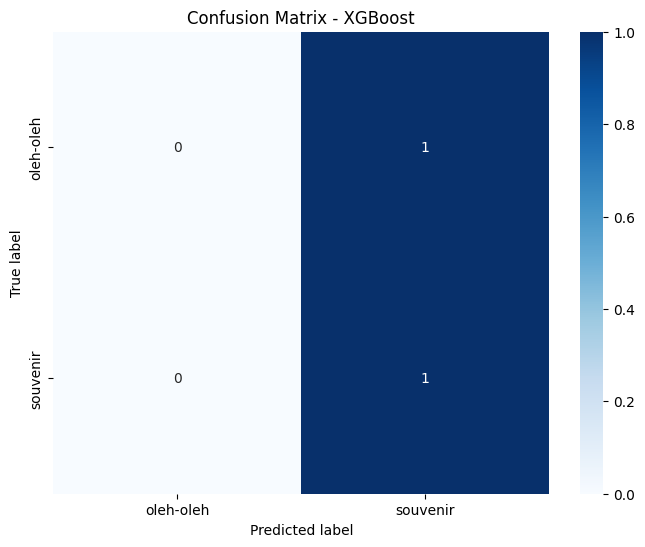


Plotting Confusion Matrix for VGG16:


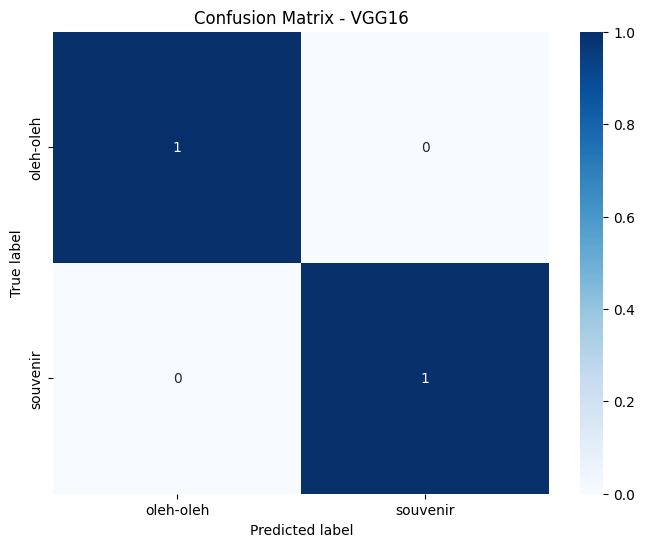

In [ ]:
# prompt: buatkan codingan menampikan gambar confusion matriks

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot Confusion Matrix for XGBoost
print("\nPlotting Confusion Matrix for XGBoost:")
cm_xgb = confusion_matrix(y_test_xgb, y_pred_xgb)
plot_confusion_matrix(cm_xgb, classes=le.classes_, title='Confusion Matrix - XGBoost')

# Plot Confusion Matrix for VGG16
print("\nPlotting Confusion Matrix for VGG16:")
cm_vgg = confusion_matrix(y_true_vgg, y_pred_vgg)
plot_confusion_matrix(cm_vgg, classes=le.classes_, title='Confusion Matrix - VGG16')


In [ ]:
# Tahap 7: Deploy opsional → Konversi model VGG ke .tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model_vgg)
tflite_model = converter.convert()
with open('model_vgg.tflite', 'wb') as f:
    f.write(tflite_model)

print("\nModel VGG16 telah dikonversi ke model_vgg.tflite")

Saved artifact at '/tmp/tmpmcjl89vp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_22')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  136436078214608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136436078210192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136436078213840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136436078208080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136436078208848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136436078213072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136436078210384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136436078211728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136436078213456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136436078214416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13643603472

In [ ]:
from IPython.display import Image as IPyImage, display

kategori = "souvenir"
jumlah = 5

subset = df_img[df_img['label'] == kategori].head(5)

# Tampilkan gambar
print(f"🖼️ Menampilkan {5} gambar pertama untuk kategori: '{souvenir}'")

for idx, row in subset.iterrows():
    print(f"\n📌 Nama Gambar: {row['image_name']}")
    print(f"🗂️ Path: {row['image_path']}")
    print(f"🏷️ Label: {row['label']}")
    display(IPyImage(filename=row['image_path']))


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_dir = "/content/drive/MyDrive/dataset/images"

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                                   rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(base_dir, target_size=(64, 64),
                                                    batch_size=32, class_mode='binary', subset='training')
val_generator = val_datagen.flow_from_directory(base_dir, target_size=(64, 64),
                                                batch_size=32, class_mode='binary', subset='validation')

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, validation_data=val_generator, epochs=100, verbose=1)

print(f"🎯 Akurasi Validasi Terakhir: {history.history['val_accuracy'][-1]*100:.2f}%")
